<a href="https://colab.research.google.com/github/SawsanT/license_plate_recognition/blob/main/Training_and_Detection_TF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Setup Paths

In [1]:
import os

In [2]:
CUSTOM_MODEL_NAME = 'my_ssd_mobnet' 
PRETRAINED_MODEL_NAME = 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8'
PRETRAINED_MODEL_URL = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz'
TF_RECORD_SCRIPT_NAME = 'generate_tfrecord.py'
LABEL_MAP_NAME = 'label_map.pbtxt'

Make a diroctory called Tensorflow and save everything inside it to make it easier, and labeled the paths of each diroctory we will use:

In [3]:
paths = {
    'WORKSPACE_PATH': os.path.join('Tensorflow', 'workspace'),
    'SCRIPTS_PATH': os.path.join('Tensorflow','scripts'),
    'APIMODEL_PATH': os.path.join('Tensorflow','models'),
    'ANNOTATION_PATH': os.path.join('Tensorflow', 'workspace','annotations'),
    'IMAGE_PATH': os.path.join('Tensorflow', 'workspace','images'),
    'MODEL_PATH': os.path.join('Tensorflow', 'workspace','models'),
    'PRETRAINED_MODEL_PATH': os.path.join('Tensorflow', 'workspace','pre-trained-models'),
    'CHECKPOINT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME), 
    'OUTPUT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'export'), 
    'TFJS_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfjsexport'), 
    'TFLITE_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfliteexport'), 
    'PROTOC_PATH':os.path.join('Tensorflow','protoc')
 }

In [4]:
files = {
    'PIPELINE_CONFIG':os.path.join('Tensorflow', 'workspace','models', CUSTOM_MODEL_NAME, 'pipeline.config'),
    'TF_RECORD_SCRIPT': os.path.join(paths['SCRIPTS_PATH'], TF_RECORD_SCRIPT_NAME), 
    'LABELMAP': os.path.join(paths['ANNOTATION_PATH'], LABEL_MAP_NAME)
}

In [5]:
for path in paths.values():
    if not os.path.exists(path):
        if os.name == 'posix':
            !mkdir -p {path}
        if os.name == 'nt':
            !mkdir {path}

Test and Train dataset was uploded into Google drive, to use it in Colab:

In [6]:
from google.colab import drive
drive.mount('/content/drive')
!ln -s /content/gdrive/My\ Drive/ /mydrive

Mounted at /content/drive


In [7]:
!cp /content/drive/MyDrive/TF/train.zip /content
!cp /content/drive/MyDrive/TF/test.zip /content

In [8]:
!unzip /content/train.zip -d /content/Tensorflow/workspace/images
!unzip /content/test.zip -d /content/Tensorflow/workspace/images

Archive:  /content/train.zip
   creating: /content/Tensorflow/workspace/images/train/
  inflating: /content/Tensorflow/workspace/images/__MACOSX/._train  
  inflating: /content/Tensorflow/workspace/images/train/Cars207.png  
  inflating: /content/Tensorflow/workspace/images/__MACOSX/train/._Cars207.png  
  inflating: /content/Tensorflow/workspace/images/train/Cars213.png  
  inflating: /content/Tensorflow/workspace/images/__MACOSX/train/._Cars213.png  
  inflating: /content/Tensorflow/workspace/images/train/Cars213.xml  
  inflating: /content/Tensorflow/workspace/images/__MACOSX/train/._Cars213.xml  
  inflating: /content/Tensorflow/workspace/images/train/Cars207.xml  
  inflating: /content/Tensorflow/workspace/images/__MACOSX/train/._Cars207.xml  
  inflating: /content/Tensorflow/workspace/images/train/Cars398.xml  
  inflating: /content/Tensorflow/workspace/images/__MACOSX/train/._Cars398.xml  
  inflating: /content/Tensorflow/workspace/images/train/Cars367.xml  
  inflating: /conten

# 1. Download TF Models Pretrained Models from Tensorflow Model Zoo and Install TFOD

In [10]:
if os.name=='nt':
    !pip install wget
    import wget

Download the Tensorflow and the required libraries:

In [11]:
if not os.path.exists(os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection')):
    !git clone https://github.com/tensorflow/models {paths['APIMODEL_PATH']}

Cloning into 'Tensorflow/models'...
remote: Enumerating objects: 68062, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 68062 (delta 6), reused 31 (delta 5), pack-reused 68029
Receiving objects: 100% (68062/68062), 576.44 MiB | 29.86 MiB/s, done.
Resolving deltas: 100% (47777/47777), done.


In [12]:
# Install Tensorflow Object Detection 
if os.name=='posix':  
    !apt-get install protobuf-compiler
    !cd Tensorflow/models/research && protoc object_detection/protos/*.proto --python_out=. && cp object_detection/packages/tf2/setup.py . && python -m pip install . 
    
if os.name=='nt':
    url="https://github.com/protocolbuffers/protobuf/releases/download/v3.15.6/protoc-3.15.6-win64.zip"
    wget.download(url)
    !move protoc-3.15.6-win64.zip {paths['PROTOC_PATH']}
    !cd {paths['PROTOC_PATH']} && tar -xf protoc-3.15.6-win64.zip
    os.environ['PATH'] += os.pathsep + os.path.abspath(os.path.join(paths['PROTOC_PATH'], 'bin'))   
    !cd Tensorflow/models/research && protoc object_detection/protos/*.proto --python_out=. && copy object_detection\\packages\\tf2\\setup.py setup.py && python setup.py build && python setup.py install
    !cd Tensorflow/models/research/slim && pip install -e . 

Reading package lists... Done
Building dependency tree       
Reading state information... Done
protobuf-compiler is already the newest version (3.0.0-9.1ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.
Processing /content/Tensorflow/models/research
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
     |████████████████████████████████| 9.8 MB 8.3 MB/s 
     |████████████████████████████████| 352 kB 49.4 MB/s 
     |████████████████████████████████| 1.8 MB 32.6 MB/s 
     |████████████████████████████████| 23.1 MB 2.8 MB/s 
     |████████████████████████████████| 1.2 MB 36.7 MB/s 
     |████████████████████████████████| 

In [13]:
!pip install tensorflow --upgrade

In [14]:
VERIFICATION_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'builders', 'model_builder_tf2_test.py')
# Verify all the Installation
!python {VERIFICATION_SCRIPT}

Running tests under Python 3.7.12: /usr/bin/python3
[ RUN      ] ModelBuilderTF2Test.test_create_center_net_deepmac
2021-12-15 23:45:57.159940: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
W1215 23:45:58.100632 140092588353408 model_builder.py:1100] Building experimental DeepMAC meta-arch. Some features may be omitted.
INFO:tensorflow:time(__main__.ModelBuilderTF2Test.test_create_center_net_deepmac): 5.62s
I1215 23:45:59.242354 140092588353408 test_util.py:2309] time(__main__.ModelBuilderTF2Test.test_create_center_net_deepmac): 5.62s
[       OK ] ModelBuilderTF2Test.test_create_center_net_deepmac
[ RUN      ] ModelBuilderTF2Test.test_create_center_net_model0 (customize_head_params=True)
INFO:tensorflow:time(__main__.ModelBuilderTF2Test.test_create_center_net_model0 (customize_head_params=True)): 1.55s
I1215 23:46:00.791155 140092588353408 test

In [15]:
import object_detection

Download the pre-trained model:

In [16]:
if os.name =='posix':
    !wget {PRETRAINED_MODEL_URL}
    !mv {PRETRAINED_MODEL_NAME+'.tar.gz'} {paths['PRETRAINED_MODEL_PATH']}
    !cd {paths['PRETRAINED_MODEL_PATH']} && tar -zxvf {PRETRAINED_MODEL_NAME+'.tar.gz'}
if os.name == 'nt':
    wget.download(PRETRAINED_MODEL_URL)
    !move {PRETRAINED_MODEL_NAME+'.tar.gz'} {paths['PRETRAINED_MODEL_PATH']}
    !cd {paths['PRETRAINED_MODEL_PATH']} && tar -zxvf {PRETRAINED_MODEL_NAME+'.tar.gz'}

--2021-12-15 23:46:44--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 173.194.198.128, 2607:f8b0:4001:c1c::80
Connecting to download.tensorflow.org (download.tensorflow.org)|173.194.198.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20515344 (20M) [application/x-tar]
Saving to: ‘ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz’

ssd_mobilenet_v2_fp 100%[===================>]  19.56M  --.-KB/s    in 0.1s    

2021-12-15 23:46:44 (132 MB/s) - ‘ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz’ saved [20515344/20515344]

ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/
ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/
ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/ckpt-0.data-00000-of-00001
ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/checkpoint
ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu

# 2. Create Label Map

In [17]:
labels = [{'name':'licence', 'id':1}]

with open(files['LABELMAP'], 'w') as f:
    for label in labels:
        f.write('item { \n')
        f.write('\tname:\'{}\'\n'.format(label['name']))
        f.write('\tid:{}\n'.format(label['id']))
        f.write('}\n')

# 3. Create TF records

In [18]:
if not os.path.exists(files['TF_RECORD_SCRIPT']):
    !git clone https://github.com/SawsanT/GenerateTFRecord {paths['SCRIPTS_PATH']}

Cloning into 'Tensorflow/scripts'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 6 (delta 1), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (6/6), done.


In [19]:
!python {files['TF_RECORD_SCRIPT']} -x {os.path.join(paths['IMAGE_PATH'], 'train')} -l {files['LABELMAP']} -o {os.path.join(paths['ANNOTATION_PATH'], 'train.record')} 
!python {files['TF_RECORD_SCRIPT']} -x {os.path.join(paths['IMAGE_PATH'], 'test')} -l {files['LABELMAP']} -o {os.path.join(paths['ANNOTATION_PATH'], 'test.record')} 

Successfully created the TFRecord file: Tensorflow/workspace/annotations/train.record
Successfully created the TFRecord file: Tensorflow/workspace/annotations/test.record


# 4. Copy Model Config to Training Folder

In [20]:
if os.name =='posix':
    !cp {os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'pipeline.config')} {os.path.join(paths['CHECKPOINT_PATH'])}
if os.name == 'nt':
    !copy {os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'pipeline.config')} {os.path.join(paths['CHECKPOINT_PATH'])}

# 5. Update Config For Transfer Learning

In [21]:
import tensorflow as tf
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format

In [22]:
config = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])

In [23]:
config

{'eval_config': metrics_set: "coco_detection_metrics"
 use_moving_averages: false,
 'eval_input_config': label_map_path: "PATH_TO_BE_CONFIGURED"
 shuffle: false
 num_epochs: 1
 tf_record_input_reader {
   input_path: "PATH_TO_BE_CONFIGURED"
 },
 'eval_input_configs': [label_map_path: "PATH_TO_BE_CONFIGURED"
 shuffle: false
 num_epochs: 1
 tf_record_input_reader {
   input_path: "PATH_TO_BE_CONFIGURED"
 }
 ],
 'model': ssd {
   num_classes: 90
   image_resizer {
     fixed_shape_resizer {
       height: 320
       width: 320
     }
   }
   feature_extractor {
     type: "ssd_mobilenet_v2_fpn_keras"
     depth_multiplier: 1.0
     min_depth: 16
     conv_hyperparams {
       regularizer {
         l2_regularizer {
           weight: 3.9999998989515007e-05
         }
       }
       initializer {
         random_normal_initializer {
           mean: 0.0
           stddev: 0.009999999776482582
         }
       }
       activation: RELU_6
       batch_norm {
         decay: 0.9969999790191

In [24]:
pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "r") as f:                                                                                                                                                                                                                     
    proto_str = f.read()                                                                                                                                                                                                                                          
    text_format.Merge(proto_str, pipeline_config)  

In [25]:
pipeline_config.model.ssd.num_classes = len(labels)
pipeline_config.train_config.batch_size = 4
pipeline_config.train_config.fine_tune_checkpoint = os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'checkpoint', 'ckpt-0')
pipeline_config.train_config.fine_tune_checkpoint_type = "detection"
pipeline_config.train_input_reader.label_map_path= files['LABELMAP']
pipeline_config.train_input_reader.tf_record_input_reader.input_path[:] = [os.path.join(paths['ANNOTATION_PATH'], 'train.record')]
pipeline_config.eval_input_reader[0].label_map_path = files['LABELMAP']
pipeline_config.eval_input_reader[0].tf_record_input_reader.input_path[:] = [os.path.join(paths['ANNOTATION_PATH'], 'test.record')]

In [26]:
config_text = text_format.MessageToString(pipeline_config)                                                                                                                                                                                                        
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "wb") as f:                                                                                                                                                                                                                     
    f.write(config_text)   

# 6. Train the model

In [27]:
TRAINING_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'model_main_tf2.py')

In [28]:
command = "python {} --model_dir={} --pipeline_config_path={} --num_train_steps=4000".format(TRAINING_SCRIPT, paths['CHECKPOINT_PATH'],files['PIPELINE_CONFIG'])

In [29]:
print(command)

python Tensorflow/models/research/object_detection/model_main_tf2.py --model_dir=Tensorflow/workspace/models/my_ssd_mobnet --pipeline_config_path=Tensorflow/workspace/models/my_ssd_mobnet/pipeline.config --num_train_steps=4000


In [31]:
!python Tensorflow/models/research/object_detection/model_main_tf2.py --model_dir=Tensorflow/workspace/models/my_ssd_mobnet --pipeline_config_path=Tensorflow/workspace/models/my_ssd_mobnet/pipeline.config --num_train_steps=4000


2021-12-15 23:49:14.149004: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
I1215 23:49:14.152400 140027754653568 mirrored_strategy.py:376] Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
INFO:tensorflow:Maybe overwriting train_steps: 4000
I1215 23:49:14.158295 140027754653568 config_util.py:552] Maybe overwriting train_steps: 4000
INFO:tensorflow:Maybe overwriting use_bfloat16: False
I1215 23:49:14.158452 140027754653568 config_util.py:552] Maybe overwriting use_bfloat16: False
Instructions for updating:
rename to distribute_datasets_from_function
W1215 23:49:14.193385 140027754653568 deprecation.py:347] From /usr/local/lib/python3.7/dist-packages/object_detection/model_lib_v2.py:564: StrategyBase.experiment

# 8. Load Train Model From Checkpoint

In [32]:
import os
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util

In [34]:
# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(paths['CHECKPOINT_PATH'], 'ckpt-5')).expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

# 9. Detect from an Image

In [35]:
import cv2 
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [36]:
category_index = label_map_util.create_category_index_from_labelmap(files['LABELMAP'])

In [37]:
IMAGE_PATH = os.path.join(paths['IMAGE_PATH'], 'test', 'Cars9.png')

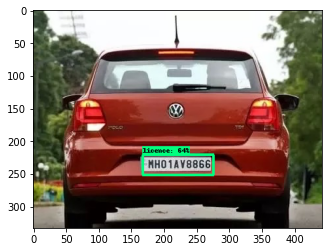

In [38]:
img = cv2.imread(IMAGE_PATH)
image_np = np.array(img)

input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections = detect_fn(input_tensor)

num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=5,
            min_score_thresh=.5,
            agnostic_mode=False)

plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
plt.show()


# 9. Text Recognistion 

1- Install the required libraries:

In [39]:
!pip install easyocr

     |████████████████████████████████| 63.6 MB 62 kB/s 


In [40]:
!pip install torch==1.8.1+cu111 torchvision==0.9.1+cu111 torchaudio===0.8.1 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |█████████████▌                  | 834.1 MB 1.6 MB/s eta 0:12:01tcmalloc: large alloc 1147494400 bytes == 0x55efe3834000 @  0x7f48cb132615 0x55efa933f4cc 0x55efa941f47a 0x55efa93422ed 0x55efa9433e1d 0x55efa93b5e99 0x55efa93b09ee 0x55efa9343bda 0x55efa93b5d00 0x55efa93b09ee 0x55efa9343bda 0x55efa93b2737 0x55efa9434c66 0x55efa93b1daf 0x55efa9434c66 0x55efa93b1daf 0x55efa9434c66 0x55efa93b1daf 0x55efa9344039 0x55efa9387409 0x55efa9342c52 0x55efa93b5c25 0x55efa93b09ee 0x55efa9343bda 0x55efa93b2737 0x55efa93b09ee 0x55efa9343bda 0x55efa93b1915 0x55efa9343afa 0x55efa93b1c0d 0x55efa93b09ee
     |█████████████████               | 1055.7 MB 556 kB/s eta 0:27:46tcmalloc: large alloc 1434370048 bytes == 0x55f027e8a000 @  0x7f48cb132615 0x55efa933f4cc 0x55efa941f47a 0x55efa93422ed 0x55efa9433e1d 0x55efa93b5e99 0x55efa93b09ee 0x55efa9343bda 0x55efa93b5d00 0x55efa93b09ee 0x55efa9343bda 0x55efa93b2737 0x55efa9434c66 0x55efa93b1d

In [41]:
import easyocr

In [42]:
detection_threshold = 0.5

In [43]:
image = image_np_with_detections
scores = list(filter(lambda x: x> detection_threshold, detections['detection_scores']))
boxes = detections['detection_boxes'][:len(scores)]
classes = detections['detection_classes'][:len(scores)]

In [44]:
width = image.shape[1]
height = image.shape[0]

[0.6642775 0.3795933 0.7554441 0.6266208]
[221.20440549 167.78024423 251.56288844 276.96640646]


[([[4, 2], [108, 2], [108, 26], [4, 26]], 'Mho 1av8866]', 0.08817985095843367)]


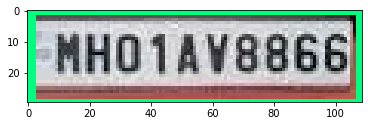

In [45]:
# Apply ROI filtering and OCR
for idx, box in enumerate(boxes):
    print(box)
    roi = box*[height, width, height, width]
    print(roi)
    region = image[int(roi[0]):int(roi[2]),int(roi[1]):int(roi[3])]
    reader = easyocr.Reader(['en'])
    ocr_result = reader.readtext(region)
    print(ocr_result)
    plt.imshow(cv2.cvtColor(region, cv2.COLOR_BGR2RGB))

In [46]:
region_threshold = 0.05

In [47]:
def filter_text(region, ocr_result, region_threshold):
    rectangle_size = region.shape[0]*region.shape[1]
    
    plate = [] 
    for result in ocr_result:
        length = np.sum(np.subtract(result[0][1], result[0][0]))
        height = np.sum(np.subtract(result[0][2], result[0][1]))
        
        if length*height / rectangle_size > region_threshold:
            plate.append(result[1])
    return plate

In [48]:
filter_text(region, ocr_result, region_threshold)

['Mho 1av8866]']

In [49]:
region_threshold = 0.6

In [50]:
def ocr_it(image, detections, detection_threshold, region_threshold):
    
    # Scores, boxes and classes above threhold
    scores = list(filter(lambda x: x> detection_threshold, detections['detection_scores']))
    boxes = detections['detection_boxes'][:len(scores)]
    classes = detections['detection_classes'][:len(scores)]
    
    # Full image dimensions
    width = image.shape[1]
    height = image.shape[0]
    
    # Apply ROI filtering and OCR
    for idx, box in enumerate(boxes):
        roi = box*[height, width, height, width]
        region = image[int(roi[0]):int(roi[2]),int(roi[1]):int(roi[3])]
        reader = easyocr.Reader(['en'])
        ocr_result = reader.readtext(region)
        
        text = filter_text(region, ocr_result, region_threshold)
        
        plt.imshow(cv2.cvtColor(region, cv2.COLOR_BGR2RGB))
        plt.show()
        print(text)
        return text, region

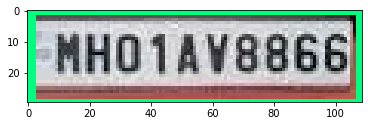

['Mho 1av8866]']


In [51]:
text, region = ocr_it(image_np_with_detections, detections, detection_threshold, region_threshold)

# 13. Zip and Export Models 

In [52]:
!tar -czf models.tar.gz {paths['CHECKPOINT_PATH']}

In [53]:
from google.colab import files
files.download('/content/models.tar.gz') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>